In [1]:
import numpy as np
import pandas as pd

In [2]:
def read_file(path):
#     df = pd.read_csv(path,delimiter = '\t',skiprows = [0,1,2,3])
    df = pd.read_csv(path,delimiter = '\t')
    return df

In [3]:
raw_data = read_file("data_mutations_consequence.txt")

In [4]:
def preprocessing(df):
    # reset column name and drop all row Nan value
#     df = df.T
#     df = df.iloc[3:,:]
    df = df.fillna("")
    return df

In [5]:
df=preprocessing(raw_data)

In [6]:
from collections import defaultdict
from sklearn import preprocessing
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the variable
fit = df.iloc[:,1:].apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
dat = df.iloc[:,1:].apply(lambda x: d[x.name].transform(x))
dat2 = df.iloc[:,0:1]
df = pd.concat([dat2, dat], axis=1) 
df.rename(columns={'\t': 'Key'}, inplace=True)

In [7]:
clic_data = read_file("data_clinical_patient.txt")
clic_data = clic_data.fillna("")
clic_data = clic_data.iloc[4:]
osstatus = clic_data.iloc[:,13]
osstatus = pd.DataFrame(data=osstatus)

In [8]:

from collections import defaultdict
from sklearn import preprocessing
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the variable
fit = osstatus.apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
osstatus = osstatus.apply(lambda x: d[x.name].transform(x))

pd2 = pd.concat([clic_data.iloc[:,0], osstatus], axis=1)
# pd2 = pd2.rename(columns={'#Patient Identifier': 'Key'}, inplace=True)

pd2

,#Patient Identifier,Overall Survival Status
4,MB-0000,2
5,MB-0002,2
6,MB-0005,1
7,MB-0006,2
8,MB-0008,1
9,MB-0010,1
10,MB-0014,2
11,MB-0020,1
12,MB-0022,1
13,MB-0025,0


In [9]:
# cat_df = df.merge(pd2, left_on='Key', right_on='#Patient Identifier')
cat_df = pd.merge(left = df, right = pd2,left_on = 'Key',right_on='#Patient Identifier')
cat_df = cat_df[cat_df['Overall Survival Status']!= 0]
cat_df.columns

Index(['Key', 'NF1', 'MAP2K4', 'MTAP', 'KDM3A', 'DTWD2', 'PIK3CA', 'NEK1',
       'CBFB', 'PRPS2',
       ...
       'CDKN2A', 'DCAF4L2', 'AGTR2', 'AFF2', 'SHANK2', 'LDLRAP1', 'NCOR1',
       'HIST1H2BC', '#Patient Identifier', 'Overall Survival Status'],
      dtype='object', length=176)

In [10]:
cat_df = cat_df.drop(['#Patient Identifier'], axis = 1)
cat_df = cat_df.drop(['Key'], axis = 1)

In [11]:
y = np.array(cat_df['Overall Survival Status'])
X = np.array(cat_df.drop(['Overall Survival Status'], axis = 1))
# X = np.array()
y[y == 2] = 0
X


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier


In [13]:
def plot_AUC_ROC(X, y):
    # Split the dataset in two equal parts
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0)

    # Set the parameters by cross-validation
#     tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4,1e-5],
#                          'C': [1, 10, 100, 1000]},
#                         {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10]}]

    # Grid Search
#     clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
#                        scoring='f1')
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)

    y_score = clf.predict(X_test)

    # Plot ROC AUC Curve
    # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_test, y_score) 
    roc_auc = auc(fpr,tpr) 
    
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 432x288 with 0 Axes>

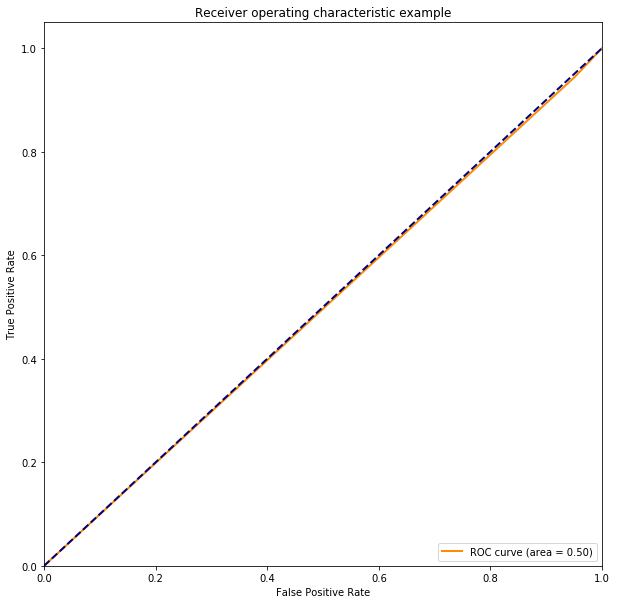

In [14]:
plot_AUC_ROC(X, y)